# DataWig Examples

## Installation

Clone the repository from git and set up virtualenv in the root dir of the package:

```
python3 -m venv venv
```

Install the package from local sources:

```
./venv/bin/pip install -e .
```

## Running DataWig
The DataWig API expects your data as a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html). Here is an example of how the dataframe might look:

|Product Type | Description           | Size | Color |
|-------------|-----------------------|------|-------|
|   Shoe      | Ideal for Running     | 12UK | Black |
| SDCards     | Best SDCard ever ...  | 8GB  | Blue  |
| Dress       | This **yellow** dress | M    | **?** |

DataWig let's you impute missing values in two ways:
  * A `.complete` functionality inspired by [`fancyimpute`](https://github.com/iskandr/fancyimpute)
  * A `sklearn`-like API with `.fit` and `.predict` methods

## Quickstart Example

### Using `AutoGluonImputer.complete`


In [9]:
# This allows to import datawig
from pathlib import Path
import sys,os
path_root = Path(os.getcwd()).parents[2]
sys.path.append(str(path_root))

In [10]:
import os, random, warnings
import numpy as np
import datawig

random.seed(0)
warnings.filterwarnings("ignore")

# generate some data with simple nonlinear dependency
df = datawig.utils.generate_df_numeric() 
# mask 10% of the values
df_with_missing = df.mask(np.random.rand(*df.shape) > .8)

# impute missing values
df_with_missing_imputed = datawig.AutoGluonImputer.complete(df_with_missing)

df['f(x) with_missing'] = df_with_missing['f(x)']
df['f(x) imputed'] = df_with_missing_imputed['f(x)']
df[-5:]

TypeError: __init__() got an unexpected keyword argument 'precision_threshold'

### Using `AutoGluonImputer.fit` and `.predict`

You can also impute values in specific columns only (called `output_column` below) using values in other columns (called `input_columns` below). DataWig currently supports imputation of categorical columns and numeric columns. Type inference is based on ``pandas`` 

#### Imputation of categorical columns

Let's first generate some random strings hidden in longer random strings:

In [11]:
df = datawig.utils.generate_df_string( num_samples=200, 
                                       data_column_name='sentences', 
                                       label_column_name='label')
df.head(n=2)

,sentences,label
0,vHqhM ZAmJ9 cq9GF h3qiP Of1Ui 56KkS,cq9GF
1,XQTck cq9GF UZd7R O2NiT 9ZMJL NQqEe,cq9GF


... and now impute them:

In [ ]:
df_train, df_test = datawig.utils.random_split(df)

imputer = datawig.AutoGluonImputer(
    input_columns=['sentences'], # column(s) containing information about the column we want to impute
    output_column='label' # the column we'd like to impute values for
    )

#Fit an imputer model on the train data
imputer.fit(train_df=df_train, time_limit=100)

#Impute missing values and return original dataframe with predictions
imputed = imputer.predict(df_test)
imputed.head(n=5)

> /home/philipp/Desktop/MLFD/datawig/datawig/autogluon_imputer.py(212)predict()
    210                 threshold_for_minimal_precision = thresholds[min(precision_above, len(thresholds)-1)]
    211                 breakpoint()
--> 212                 if precision_threshold > 0:
    213                     above_precision = class_mask & \
    214                         (probas[label] >= threshold_for_minimal_precision)



ipdb>  threshold_for_minimal_precision


0.996666669845581


ipdb>  precision_above


0


ipdb>  precisions


array([1., 1., 1.])


ipdb>  precision_threshold


0.0


ipdb>  precisions >= precision_threshold


array([ True,  True,  True])


ipdb>  (precisions >= precision_threshold).nonzero()


(array([0, 1, 2]),)


ipdb>  (precisions >= precision_threshold).nonzero()[0][0]


0


ipdb>  precision_above


0


ipdb>  len(thresholds)


2


ipdb>  len(thresholds)-1


1


ipdb>  min(precision_above, len(thresholds)-1)


0
--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user
> /home/philipp/Desktop/MLFD/datawig/datawig/autogluon_imputer.py(211)predict()
    209 
    210                 # get index of first fitted threshold that surpasses threshold
--> 211                 precision_above = (precisions >= precision_threshold).nonzero()[0][0]
    212                 threshold_for_minimal_precision = thresholds[min(precision_above, len(thresholds)-1)]
    213                 if precision_threshold > 0:



#### Imputation of numerical columns

Imputation of numerical values works just like for categorical values.

Let's first generate some numeric values with a quadratic dependency:


In [4]:
import datawig

df = datawig.utils.generate_df_numeric( num_samples=200, 
                                        data_column_name='x', 
                                        label_column_name='y')         
df.head(n=5)

,x,y
0,1.229925,1.505476
1,-0.285627,0.076257
2,0.801471,0.647639
3,0.529762,0.282723
4,2.520550,6.373606


... and now impute those, too:

In [7]:
df_train, df_test = datawig.utils.random_split(df)

imputer = datawig.AutoGluonImputer(
    input_columns=['x'], # column(s) containing information about the column we want to impute
    output_column='y', # the column we'd like to impute values for
    )

#Fit an imputer model on the train data
imputer.fit(train_df=df_train, time_limit=100)

#Impute missing values and return original dataframe with predictions
imputed = imputer.predict(df_test)
imputed.head(n=5)

		No module named 'mxnet'


,x,y,y_imputed
57,1.464692,2.149859,2.101123
31,-2.687957,7.225748,7.200390
65,2.226667,4.958026,5.079371
140,2.124441,4.502884,4.463196
89,-0.434246,0.176235,0.195624


#### Comparison between empirical precision thresholds and the ones estimated by AutoGluonImputer

In [9]:
import pandas as pd
from sklearn.metrics import classification_report

from sklearn.datasets import (
    load_diabetes,
    load_wine,
    make_hastie_10_2
)

def get_data(data_fn, noise=3e-1):
    X, y = data_fn(n_samples=10000)
    X = X + np.random.randn(*X.shape) * noise
    return pd.DataFrame(np.vstack([X.T, y]).T, columns= [str(i) for i in range(X.shape[-1] + 1)])

In [32]:
X = get_data(make_hastie_10_2)
label = X.columns[-1]
X[label] = X[label].astype(str)
features = X.columns[:-1]
df_train, df_test = datawig.utils.random_split(X.copy())

imputer = datawig.AutoGluonImputer(
    input_columns=[x for x in X.columns if x != label], # column(s) containing information about the column we want to impute
    output_column=label, # the column we'd like to impute values for
    verbosity=2,
    
)

In [33]:
#Fit an imputer model on the train data
imputer.fit(train_df=df_train, time_limit=10)

Beginning AutoGluon training ... Time limit = 10s
AutoGluon will save models to "./agModels/AutoGluonImputer/"
AutoGluon Version:  0.2.0
Train Data Rows:    7200
Train Data Columns: 10
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Train Data Class Count: 2
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    3472.48 MB
	Train Data (Original)  Memory Usage: 0.58 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 10 | ['0', '1', '2', '3', '4', ...]

In [35]:
features = X.columns[:-1]
precisions = []
for precision_threshold in [0.1, 0.5, 0.9, 0.95, .99]:
    imputed = imputer.predict(df_test[features], 
                          precision_threshold=precision_threshold, 
                          inplace=True)
    report = classification_report(df_test[label],imputed[label+"_imputed"].fillna(""), output_dict=True)
    rep = classification_report(df_test[label],imputed[label+"_imputed"].fillna(""))
    
    precisions.append({
        'precision_threshold': precision_threshold,
        'empirical_precision_on_test_set': np.mean([report['-1.0']['precision'],report['1.0']['precision']])
    })

<AxesSubplot:>

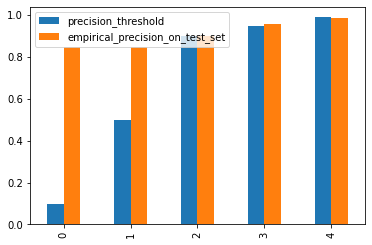

In [17]:
pd.DataFrame(precisions).plot.bar()

In [26]:
df_precisions = pd.DataFrame(precisions)
df_precisions

,precision_threshold,empirical_precision_on_test_set
0,0.10,0.861234
1,0.50,0.861234
2,0.90,0.917931
3,0.95,0.962769
4,0.99,0.988919


In [33]:
df_precisions = pd.DataFrame(precisions)
precision_deviations = df_precisions['empirical_precision_on_test_set'] \
                            - df_precisions['precision_threshold'] + 0.01 
    
all(precision_deviations > 0)

True